In [2]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from skimage import io
from skimage.transform import resize
import os
from torch.utils.data import DataLoader
from torch import nn
import torch.functional as f
from skimage import color
import numpy as np
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import cv2

In [66]:
os.chdir('/Users/devam/PycharmProjects/BinomialIDCClassifer')

class IDCDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        image = resize(image, (50, 50))
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label

In [67]:
dataset = IDCDataset(csv_file='cancers.csv', root_dir='dset', transform=ToTensor())

In [68]:
trainset, testset = torch.utils.data.random_split(dataset, [1500, 500])

In [69]:
trainloader = DataLoader(dataset=trainset, batch_size=200, shuffle=True)
validloader = DataLoader(dataset=trainset, batch_size=200, shuffle=True)

In [70]:
for x, y in trainloader:
    print(x)
    break

tensor([[[[0.8941, 0.9333, 0.9490,  ..., 0.9373, 0.9608, 0.9451],
          [0.9020, 0.9490, 0.9490,  ..., 0.9569, 0.9451, 0.9490],
          [0.9255, 0.9412, 0.9490,  ..., 0.9255, 0.8980, 0.9490],
          ...,
          [0.9490, 0.9451, 0.9490,  ..., 0.9451, 0.9490, 0.9490],
          [0.9490, 0.9451, 0.9412,  ..., 0.9412, 0.9529, 0.9490],
          [0.9490, 0.9412, 0.9412,  ..., 0.9490, 0.9529, 0.9529]],

         [[0.8431, 0.9020, 0.9451,  ..., 0.9137, 0.9451, 0.9490],
          [0.8235, 0.9255, 0.9490,  ..., 0.9412, 0.9294, 0.9216],
          [0.8745, 0.9137, 0.9490,  ..., 0.8549, 0.8275, 0.9059],
          ...,
          [0.9333, 0.9373, 0.9373,  ..., 0.9490, 0.9451, 0.9412],
          [0.9412, 0.9490, 0.9490,  ..., 0.9255, 0.9412, 0.9412],
          [0.9412, 0.9412, 0.9373,  ..., 0.8980, 0.9412, 0.9412]],

         [[0.8784, 0.9137, 0.9451,  ..., 0.9373, 0.9451, 0.9725],
          [0.8667, 0.9373, 0.9490,  ..., 0.9451, 0.9490, 0.9216],
          [0.8941, 0.9412, 0.9412,  ..., 0

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5,5), stride=5)
        self.r1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.c2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(2, 2), stride=1)
        self.r2 = nn.ReLU()
        self.maxpool2=nn.MaxPool2d(kernel_size=(3, 3), stride=1)
        self.lin1 = nn.Linear(2 * 2 * 20, 150)
        self.lin2 = nn.Linear(150, 2)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.c1(x)
        x = self.r1(x)
        x = self.maxpool1(x)
        x = self.c2(x)
        x = self.r2(x)
        x = self.maxpool2(x)
        x = x.flatten(1)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.logsoftmax(x)
        return torch.exp(x)

In [72]:
model = Net()

In [21]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [20]:
def train(epochs):
    total = 0
    TRAINING_LOSS = []
    VALID_ACC = []
    for epoch in range(epochs):
        for x, y in trainloader:
            x = torch.from_numpy(np.asarray(x)).float()
            y = torch.from_numpy(np.asarray(y)).float()
            yhat = model(x)
            loss = criterion(yhat.max(dim=1)[0], y)
            TRAINING_LOSS.append(loss.data.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        correct = 0
        total = 0
        for x, y in validloader:
            x = torch.from_numpy(np.asarray(x)).float()
            y = torch.from_numpy(np.asarray(y)).float()
            yhat = model(x)
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            total += len(y)
            accuracy = 100 * (correct / total)
            VALID_ACC.append(accuracy)

    return TRAINING_LOSS, VALID_ACC

In [48]:
trainingdata = train(50)

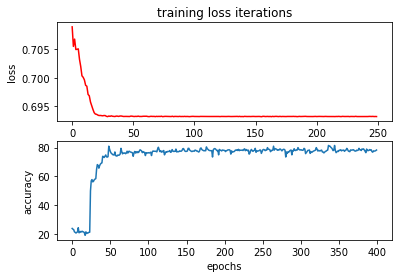

In [610]:
plt.subplot(2, 1, 1)
plt.plot(trainingdata[0], 'r')
plt.ylabel('loss')
plt.title('training loss iterations')
plt.subplot(2, 1, 2)
plt.plot(trainingdata[1])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(trainingdata[0], 'r')
plt.ylabel('loss')
plt.title('training loss iterations')
plt.subplot(2, 1, 2)
plt.plot(trainingdata[1])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [611]:
trainingdata[1]

[24.0,
 23.5,
 23.166666666666664,
 21.625,
 21.3,
 20.833333333333336,
 21.285714285714285,
 21.6,
 24.5,
 21.0,
 21.333333333333336,
 21.875,
 21.6,
 22.083333333333332,
 21.714285714285715,
 21.6,
 21.0,
 19.25,
 21.666666666666668,
 20.5,
 20.9,
 20.916666666666668,
 21.357142857142858,
 21.4,
 50.0,
 56.99999999999999,
 57.833333333333336,
 56.25,
 56.699999999999996,
 57.75,
 58.214285714285715,
 58.53333333333334,
 65.0,
 68.25,
 67.66666666666666,
 65.75,
 67.5,
 68.58333333333333,
 69.14285714285714,
 69.39999999999999,
 74.0,
 73.75,
 73.16666666666667,
 74.0,
 74.9,
 73.58333333333333,
 73.42857142857143,
 73.73333333333333,
 81.0,
 79.0,
 77.33333333333333,
 76.25,
 75.8,
 75.16666666666667,
 75.0,
 74.86666666666667,
 77.0,
 74.5,
 74.16666666666667,
 74.25,
 74.9,
 74.66666666666667,
 74.92857142857143,
 75.66666666666667,
 79.5,
 77.25,
 75.66666666666667,
 76.25,
 76.2,
 76.33333333333333,
 75.78571428571429,
 76.2,
 77.5,
 76.25,
 77.33333333333333,
 77.5,
 77.0,
 76.8

Peak accuracy: 81.5%
Ending Accuracy: 78.33%

Peak could have been conserved with early stopping

Overall performance could be optimized using drop-out techniques as well as more convolution layers (LeNet 50 derivative was used for this)

In [613]:
torch.save(model.state_dict(), 'finalmodel.pt')

In [614]:
torch.save(optimizer.state_dict(), 'finaloptimizer.pt')

In [73]:
model.load_state_dict(torch.load('finalmodel.pt'))

<All keys matched successfully>

In [74]:
correct = 0
total = 0
for x, y in validloader:
            x = torch.from_numpy(np.asarray(x)).float()
            y = torch.from_numpy(np.asarray(y)).float()
            yhat = model(x)
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            total += len(y)
            accuracy = 100 * (correct / total)
            print(accuracy)

77.5
74.75
75.83333333333333
77.0
76.4
77.66666666666666
77.57142857142857
77.86666666666666
